<a href="https://colab.research.google.com/github/ShadaFathima/ML-DL/blob/main/negative_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
# 1. Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Preprocess data
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [ ]:
# 2. Build a simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Define Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# 3. Train the model
model.fit(x_train, y_train_cat, epochs=10, batch_size=128, validation_split=0.1, callbacks=[early_stop])

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8724 - loss: 0.4530 - val_accuracy: 0.9802 - val_loss: 0.0784
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9778 - loss: 0.0750 - val_accuracy: 0.9845 - val_loss: 0.0583
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9853 - loss: 0.0493 - val_accuracy: 0.9865 - val_loss: 0.0552
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9890 - loss: 0.0356 - val_accuracy: 0.9880 - val_loss: 0.0459
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9923 - loss: 0.0254 - val_accuracy: 0.9872 - val_loss: 0.0495
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9938 - loss: 0.0195 - val_accuracy: 0.9887 - val_loss: 0.0489
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9959 - loss: 0.0145 - val_accuracy: 0.9862 - val_loss: 0.0564


In [ ]:
# Evaluate before unlearning
loss, acc = model.evaluate(x_test, y_test_cat)
print(f"Before Unlearning - Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9837 - loss: 0.0533
Before Unlearning - Test Accuracy: 0.9865


In [ ]:
# 4. Negative Gradient Unlearning for digit "3"
unlearn_idx = np.where(y_train == 3)[0]  # Indices of all '3's
x_unlearn = x_train[unlearn_idx]
y_unlearn = y_train_cat[unlearn_idx]

In [ ]:

# Create custom training loop for negative gradient
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
epochs_unlearn = 20  # few steps for unlearning
for epoch in range(epochs_unlearn):
    with tf.GradientTape() as tape:
        preds = model(x_unlearn, training=True)
        loss_value = loss_fn(y_unlearn, preds)
    grads = tape.gradient(loss_value, model.trainable_variables)
    # NEGATIVE gradient step → we ADD instead of subtract
    negative_grads = [-g for g in grads]
    optimizer.apply_gradients(zip(negative_grads, model.trainable_variables))
    print(f"Unlearning Epoch {epoch+1}/{epochs_unlearn}, Loss: {loss_value.numpy():.4f}")

Unlearning Epoch 1/20, Loss: 2.4286
Unlearning Epoch 2/20, Loss: 2.6990
Unlearning Epoch 3/20, Loss: 2.9905
Unlearning Epoch 4/20, Loss: 3.3037
Unlearning Epoch 5/20, Loss: 3.6390
Unlearning Epoch 6/20, Loss: 3.9966
Unlearning Epoch 7/20, Loss: 4.3767
Unlearning Epoch 8/20, Loss: 4.7792
Unlearning Epoch 9/20, Loss: 5.2040
Unlearning Epoch 10/20, Loss: 5.6509
Unlearning Epoch 11/20, Loss: 6.1194
Unlearning Epoch 12/20, Loss: 6.6089
Unlearning Epoch 13/20, Loss: 7.1188
Unlearning Epoch 14/20, Loss: 7.6483
Unlearning Epoch 15/20, Loss: 8.1959
Unlearning Epoch 16/20, Loss: 8.7605
Unlearning Epoch 17/20, Loss: 9.3408
Unlearning Epoch 18/20, Loss: 9.9352
Unlearning Epoch 19/20, Loss: 10.5428
Unlearning Epoch 20/20, Loss: 11.1622


In [ ]:

# 5. Evaluate after unlearning
loss, acc = model.evaluate(x_test, y_test_cat)
print(f"After Unlearning - Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8129 - loss: 1.4072
After Unlearning - Test Accuracy: 0.8226


In [ ]:

# Check accuracy specifically on digit "3"
x_test_3 = x_test[y_test == 3]
y_test_3 = y_test_cat[y_test == 3]
loss_3, acc_3 = model.evaluate(x_test_3, y_test_3, verbose=0)
print(f"Accuracy on Digit '3' after Unlearning: {acc_3:.4f}")

Accuracy on Digit '3' after Unlearning: 0.0129


In [ ]:
# Check accuracy on other digits
for digit in range(10):
    if digit != 3:
        idx = y_test == digit
        _, acc_digit = model.evaluate(x_test[idx], y_test_cat[idx], verbose=0)
        print(f"Digit {digit} Accuracy: {acc_digit:.4f}")

Digit 0 Accuracy: 0.9561
Digit 1 Accuracy: 0.9850
Digit 2 Accuracy: 0.9225
Digit 4 Accuracy: 0.9868
Digit 5 Accuracy: 0.6558
Digit 6 Accuracy: 0.9582
Digit 7 Accuracy: 0.9640
Digit 8 Accuracy: 0.9979
Digit 9 Accuracy: 0.7641


In [ ]:
# 6. Test on one image from the dataset
import matplotlib.pyplot as plt

# Pick one test image (e.g., first '3' or any random image)
test_idx = np.where(y_test == 3)[0][2]  # first '3' sample
test_img = x_test[test_idx].reshape(1, 28, 28, 1)
true_label = y_test[test_idx]

In [ ]:
# Predict after unlearning
pred_label = np.argmax(model.predict(test_img))
print(f"True Label: {true_label}, Predicted Label after Unlearning: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
True Label: 3, Predicted Label after Unlearning: 8


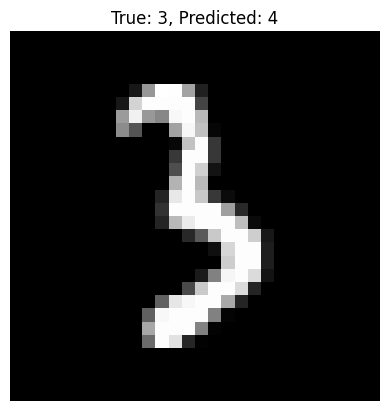

In [ ]:

# Show the image
plt.imshow(test_img.reshape(28, 28), cmap="gray")
plt.title(f"True: {true_label}, Predicted: {pred_label}")
plt.axis("off")
plt.show()
